In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#pip install albumentations==0.4.6
#pip install torchmetrics
#pip install tensorboard

In [ ]:
%cd drive/MyDrive/.........

In [2]:
from preprocess import *
from dataset import FloodNetDataset
from dataset_disk import FloodNetDatasetDisk
from dataset_old import FloodNetDatasetDiskOld

from focalloss import FocalLoss
from training import *
from testing import *

from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import torch.nn as nn
import cv2
from torchvision.transforms.transforms import ToTensor
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchmetrics import JaccardIndex
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter

# **INFERENCE EXAMPLES**

In [ ]:
DEVICE='cpu'
model = get_deeplab_evaled("../TRAINING_LOGS/models_saved/model_902.pth", DEVICE)

In [ ]:
new_transform = A.Compose([
                       A.Resize(750, 1000),
                       ToTensorV2(),   #always last
                       
])

ds = FloodNetDatasetDisk(root_dir="../DATASET_oversampled/test", transform=new_transform)

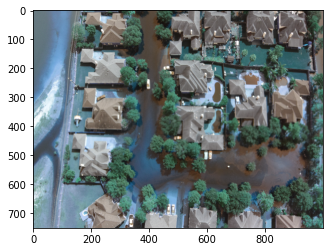

In [45]:
img, mask = ds.__getitem__(53)
plt.imshow(img.permute(1,2,0))

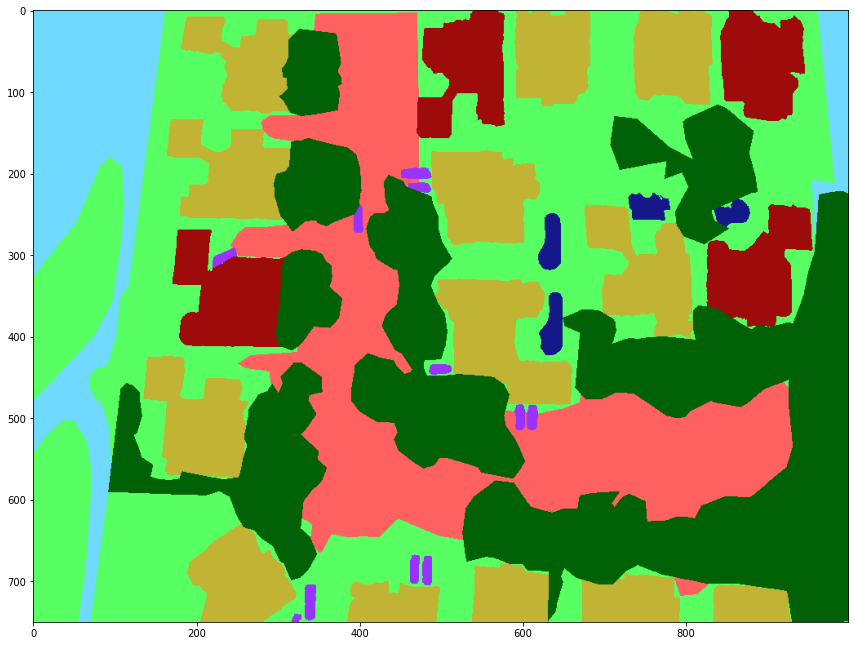

In [46]:
displayMask(mask)

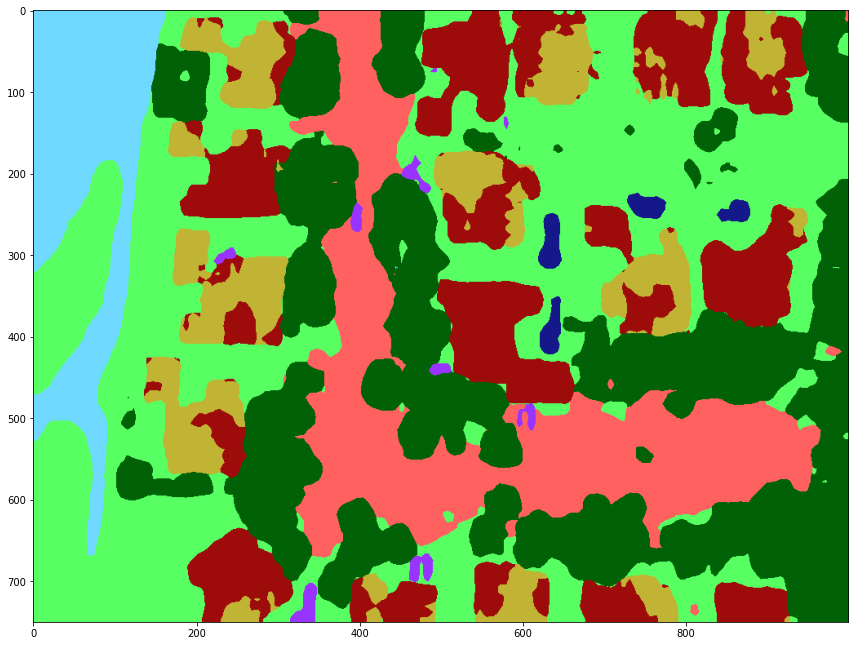

In [48]:
out=model(torch.unsqueeze(img, 0))['out']
displayMask(torch.argmax(torch.squeeze(out, 0),0))

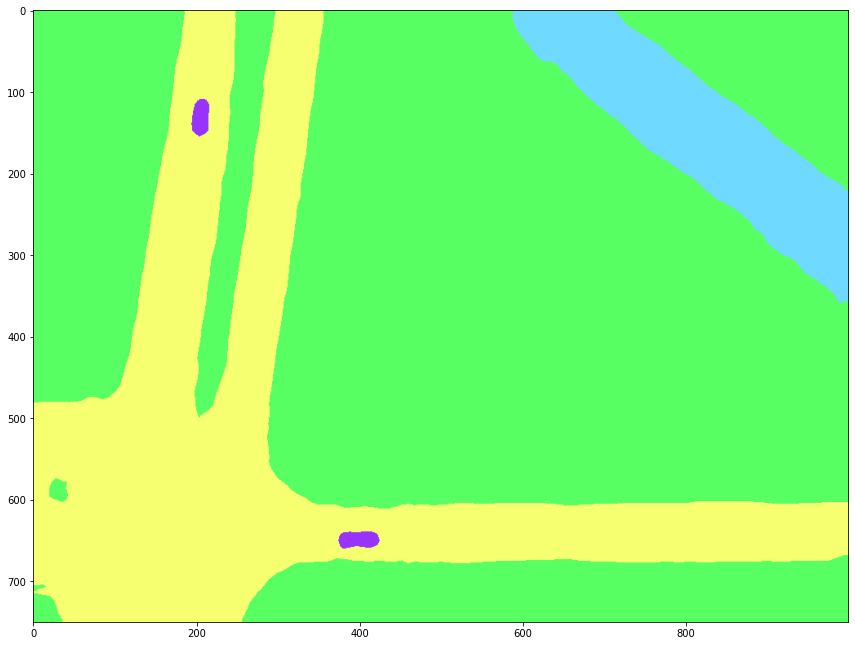

In [5]:
img, mask = ds.__getitem__(0)
out=model(torch.unsqueeze(img, 0))['out']
saveMask(torch.argmax(torch.squeeze(out, 0),0), path="../TEST_INFERENCE/prova.png")

## SAVING ALL INFERENCE OUTPUTS

In [ ]:
for index in range(len(ds)):
    print(index)
    img, mask = ds.__getitem__(index)
    out=model(torch.unsqueeze(img, 0))['out']
    saveMask(torch.argmax(torch.squeeze(out, 0),0), path="../TEST_INFERENCE/"+str(index)+".png")



# TESTING

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model = get_deeplab_evaled("../TRAINING_LOGS/models_saved/model_288.pth", DEVICE)

In [ ]:
test_transform = A.Compose([
                       A.Resize(750, 1000),
                       A.HorizontalFlip(p=0.2),
                       A.VerticalFlip(p=0.2),
                       A.RandomBrightnessContrast(p=0.2),
                       ToTensorV2(),   #always last
                       
])

ds = FloodNetDatasetDisk(root_dir="../DATASET/test", transform=test_transform)

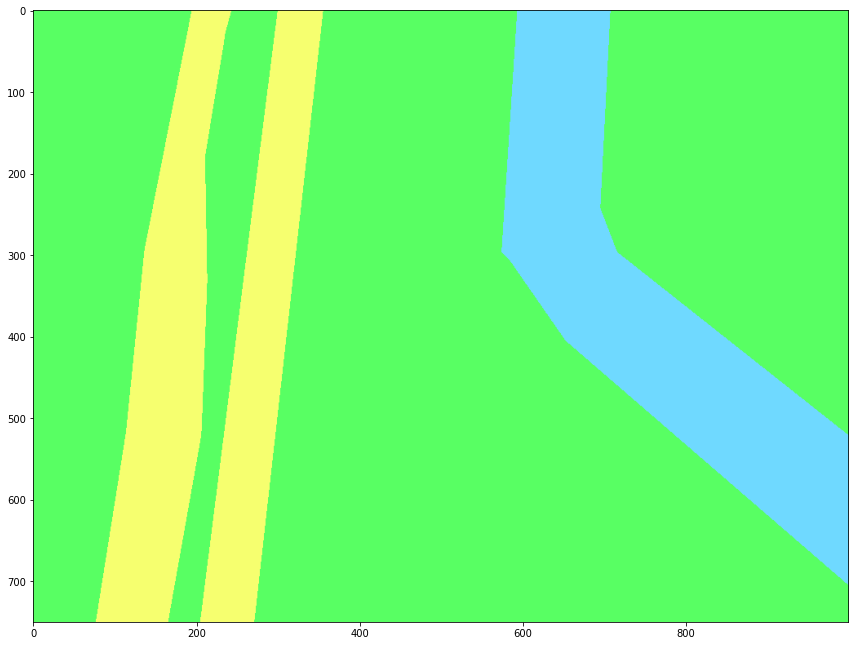

In [ ]:
#### showing a mask in the test ds
img, mask = displayMaskId(ds, 1)

tensor([[[9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9],
         ...,
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9]]])

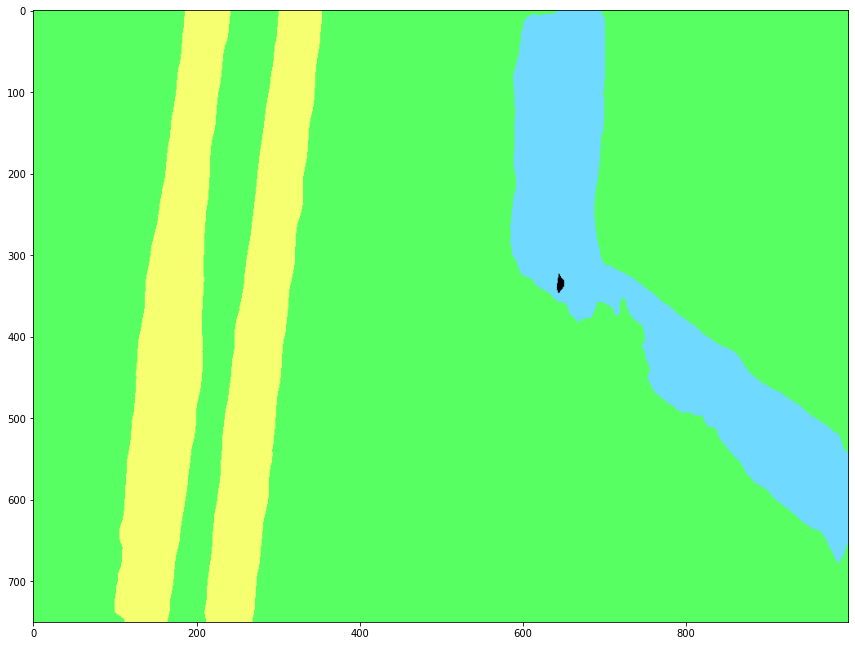

In [ ]:
### showing the prediction of the model on the same image of the above mask
displayPrediction(model, DEVICE, img)

# ACCURACY

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model = get_deeplab_evaled("../TRAINING_LOGS/models_saved/model_264.pth", DEVICE)
#model = get_deeplab_evaled("../history/config8_baseline_deeplabv3/models_saved/model_200.pth", DEVICE)

In [ ]:
test_transform = A.Compose([
                       A.Resize(750, 1000),
                       ToTensorV2(),   #always last                     
])

ds_test = FloodNetDatasetDisk(root_dir="../DATASET_oversampled/test", transform=test_transform)

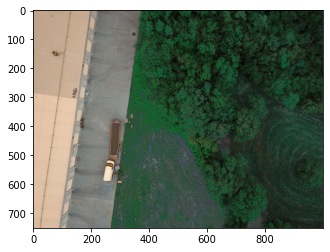

In [ ]:
img, mask = ds_test.__getitem__(300)
plt.imshow(img.permute(1,2,0))

In [ ]:
img.shape, mask.shape

(torch.Size([3, 750, 1000]), torch.Size([750, 1000]))

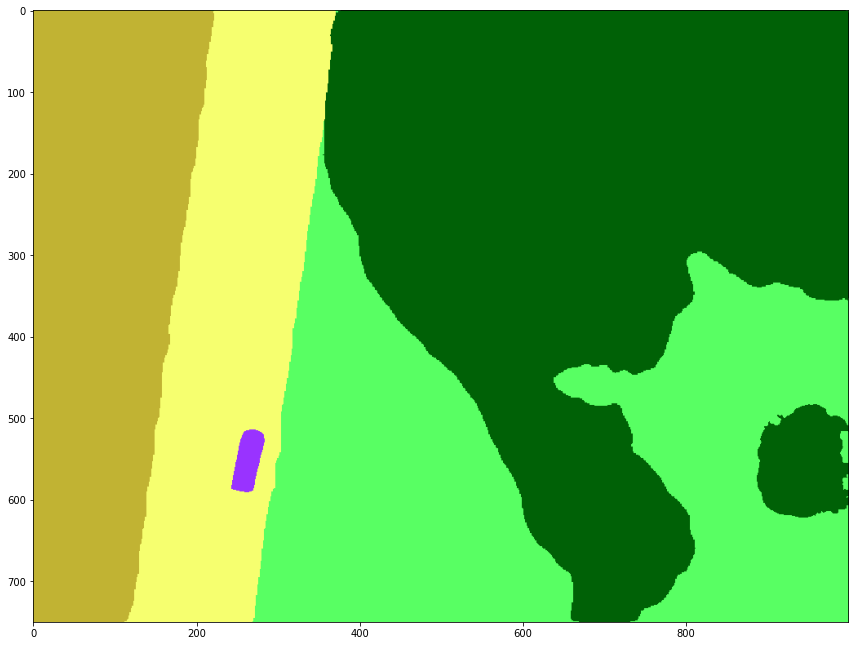

In [ ]:
displayMask(mask)

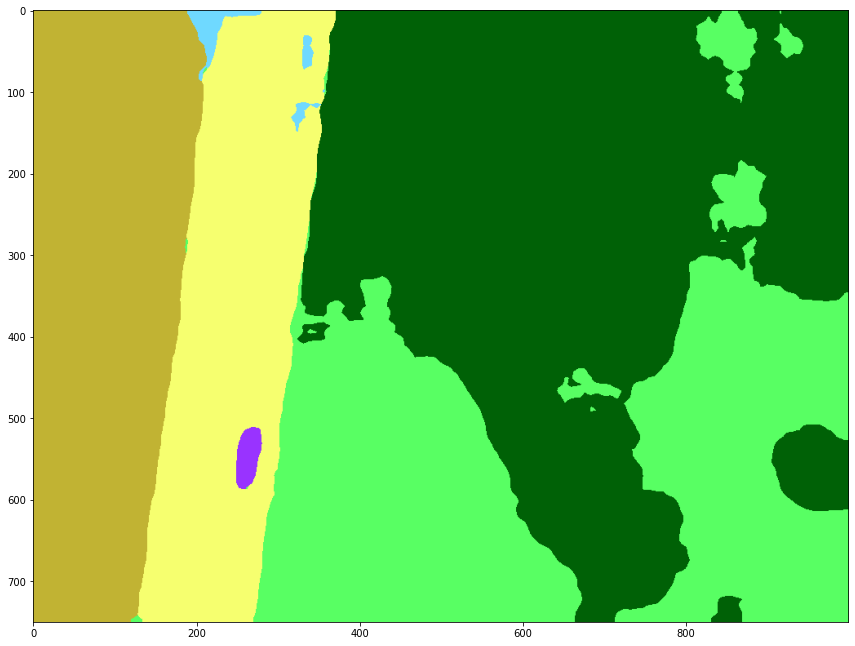

In [ ]:
out = model(img.unsqueeze(0).to(DEVICE))['out']
displayMask(torch.argmax(out, dim=1).squeeze(0).cpu())

## CALCULATING ACCURACY ON THE EXAMPLE PREDICTION

In [ ]:
## using torchmetrics function
accuracy(output=np.array(torch.argmax(out, dim=1).squeeze(0).cpu()), mask=np.array(mask))

0.9396266666666667

In [ ]:
## calculating the average accuracy on all the test ds
calculateAccuracy(ds=ds_test, model=model, device=DEVICE)

## average acc. = 0.89

Calculating Accuracy 
[0\415] 0.9619986666666667
[1\415] 0.9147813333333333
[2\415] 0.97418
[3\415] 0.981864
[4\415] 0.974364
[5\415] 0.9773853333333333
[6\415] 0.975908
[7\415] 0.9789453333333333
[8\415] 0.9758026666666667
[9\415] 0.945048
[10\415] 0.9377973333333334
[11\415] 0.927964
[12\415] 0.9325373333333333
[13\415] 0.9200173333333334
[14\415] 0.906548
[15\415] 0.9348706666666666
[16\415] 0.9697986666666667
[17\415] 0.964632
[18\415] 0.903832
[19\415] 0.9152586666666667
[20\415] 0.93106
[21\415] 0.9400413333333333
[22\415] 0.776184
[23\415] 0.8188333333333333
[24\415] 0.8612853333333333
[25\415] 0.8940306666666666
[26\415] 0.8743293333333333
[27\415] 0.8923066666666667
[28\415] 0.8944226666666667
[29\415] 0.8790146666666667
[30\415] 0.8736466666666667
[31\415] 0.8948613333333333
[32\415] 0.922476
[33\415] 0.939364
[34\415] 0.9428413333333333
[35\415] 0.962184
[36\415] 0.902164
[37\415] 0.9578546666666666
[38\415] 0.3977466666666667
[39\415] 0.9033653333333334
[40\415] 0.838401333

(371.1665013333332, 0.8943771116465861)

## CALCULATING mIoU 

In [ ]:
new_transform = A.Compose([
                       A.Resize(750, 1000),
                       ToTensorV2(),   #always last
                       
])

old_transform = A.Compose([
                       A.Resize(600, 800),
                       ToTensorV2(),   #always last
                       
])

ds = FloodNetDatasetDisk(root_dir="../DATASET_oversampled/test", transform=nuovo_transform)
#ds = FloodNetDatasetDisk(root_dir="../DATASET_old/test", transform=nuovo_transform)

#ds = FloodNetDatasetDiskOld(root_dir="../DATASET_old/test", normalize=True, transform=vecchio_transform)

In [ ]:
ds.__getitem__(0)[0].shape

In [ ]:
np.unique(ds.__getitem__(0)[0])

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model = get_deeplab_evaled("../history/config8_baseline_deeplabv3/models_saved/model_329.pth", DEVICE)
#model = get_deeplab_evaled("../TRAINING_LOGS/models_saved/model_329.pth", DEVICE)
#model = get_deeplab_evaled("../TRAINING_LOGS/models_saved/model_704.pth", DEVICE)

#model = get_deeplab_evaled("../history/config_1/models_saved/model_59_final.pth", DEVICE)
#model = get_deeplab_evaled("../history/config_5/models_saved/model_83.pth", DEVICE)


In [ ]:
#### mIoU test

for x in range(329, 335):
    print(x)
    model = get_deeplab_evaled("../history/config8_baseline_deeplabv3/models_saved/model_"+str(x)+".pth", DEVICE)
    mIoU, dict_classes = calculatemIoU(ds, model, DEVICE)

329
<All keys matched successfully>
Calculating mIoU 
[414\415] Total IoU of class 1: 0.02081549395634118
Total IoU of class 2: 0.05339253081229657
Total IoU of class 3: 0.022066923599853634
Total IoU of class 4: 0.30986994094177883
Total IoU of class 5: 0.16712899794143934
Total IoU of class 6: 0.24247777800981618
Total IoU of class 7: 0.04365234069109524
Total IoU of class 8: 1.1698583708798018e-05
Total IoU of class 9: 0.4744018901709128
--- mIoU time: 230.42800617218018 seconds ---
Mean IoU: 0.1482019549674714
330
<All keys matched successfully>
Calculating mIoU 
[414\415] Total IoU of class 1: 0.02414700608475502
Total IoU of class 2: 0.08048928672626139
Total IoU of class 3: 0.020839181279032306
Total IoU of class 4: 0.20027656491446588
Total IoU of class 5: 0.10453258994266473
Total IoU of class 6: 0.25257459422149925
Total IoU of class 7: 0.019331658584909546
Total IoU of class 8: 0.00024179850490533975
Total IoU of class 9: 0.5590437954839924
--- mIoU time: 229.4031002521515 s

KeyboardInterrupt: ignored